<a id='top'>Top</a>








High Level Plan: 
1. Import data 
2. Explore: Do Exploratory Data Analysis. Find out how the data looks like in raw format.
3. Cleanse: Clean the data for any null records by pruning or imputing
4. Feature Engineering:  Identify what category of ML modelling is required.
5. Modelling: Create a ML model and test. Also save the model to be imported for runing in stream data processing






<a id='import'></a>
# 1. Import

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz
from sklearn2pmml import sklearn2pmml, PMMLPipeline
from sklearn2pmml.decoration import CategoricalDomain
from xgboost.sklearn import XGBClassifier

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
#Import dataset from CSV file
df = pd.read_csv('../PS_20174392719_1491204439457_log.csv')


<a href='#top'>back to top</a>

<a id='EDA'></a>
# 2. Exploratory Data Analysis


In [5]:
#List the columns
list(df)

['step',
 'type',
 'amount',
 'nameOrig',
 'oldbalanceOrg',
 'newbalanceOrig',
 'nameDest',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud']

In [6]:
print(df.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [7]:
#Check whether any Null values are present
df.isnull().values.any()

False

In [8]:
#Idenfity Fradulent transactions, Ratio and some basic understanding of other factors
totalrecords = len(df)
print ('Total number of Records =', totalrecords)

is_fraud = len(df.loc[df.isFraud == 1])

print ('Total number of Records with Fraudulent Transactions = {}'.format(len(df.loc[df.isFraud == 1])))
print ('Total number of Records with Flagged Fraudulent Transactions = {}'.format(len(df.loc[df.isFlaggedFraud == 1])))

       
print('Percentage Ratio of Fradulent Transactions=', is_fraud*100/totalrecords)
print ('Total number of Records with type PAYMENT = {}'.format(len(df.loc[df.type == "PAYMENT"]))) 
print ('Total number of Records with type TRANSFER = {}'.format(len(df.loc[df.type == "TRANSFER"])))
print ('Total number of Records with type CASH_IN = {}'.format(len(df.loc[df.type == "CASH_IN"])))
print ('Total number of Records with type CASH_OUT = {}'.format(len(df.loc[df.type == "CASH_OUT"])))
print ('Total number of Records with type DEBIT = {}'.format(len(df.loc[df.type == "DEBIT"])))

Total number of Records = 6362620
Total number of Records with Fraudulent Transactions = 8213
Total number of Records with Flagged Fraudulent Transactions = 16
Percentage Ratio of Fradulent Transactions= 0.12908204481801522
Total number of Records with type PAYMENT = 2151495
Total number of Records with type TRANSFER = 532909
Total number of Records with type CASH_IN = 1399284
Total number of Records with type CASH_OUT = 2237500
Total number of Records with type DEBIT = 41432


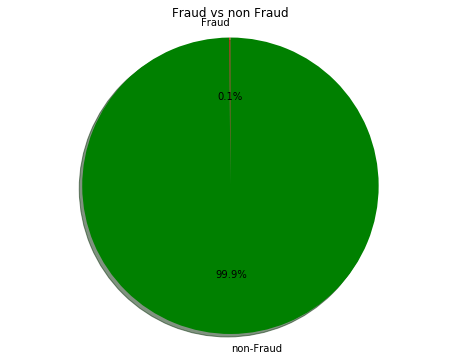

In [9]:
x =len(df[df['isFraud'] == 1])
y = len(df[df['isFraud']== 0])
plt.figure(figsize=(8,6))
# Data to plot
plt.title('Fraud vs non Fraud')
labels = 'Fraud','non-Fraud'
sizes = [x,y]
colors = ['red', 'green']
explode = (0, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=90)
 
plt.axis('equal')
plt.show()

In [10]:
#Observation: Ratio of Fraudulent transaction is very small

In [11]:
print('Fraudulent transactions types are {}'.format(list(df.loc[df.isFraud == 1].type.drop_duplicates().values))) 

Fraudulent transactions types are ['TRANSFER', 'CASH_OUT']


In [12]:


print ('Total number of Records with  fraudulent TRANSFERs = {}'.format(len(df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]))) # 4097

print ('Total number of Records with fraudulent CASH_OUTs = {}'.format(len(df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]))) # 4116

print ('Total number of Records with isFlaggedfraudulent with TRANSFERs = {}'.format(len(df.loc[(df.isFlaggedFraud   == 1) & (df.type == 'TRANSFER')])))

print ('Total number of Records with  isFlaggedfraudulent with CASH_OUTs = {}'.format(len(df.loc[(df.isFlaggedFraud == 1) & (df.type == 'CASH_OUT')])))




Total number of Records with  fraudulent TRANSFERs = 4097
Total number of Records with fraudulent CASH_OUTs = 4116
Total number of Records with isFlaggedfraudulent with TRANSFERs = 16
Total number of Records with  isFlaggedfraudulent with CASH_OUTs = 0


<a href='#top'>back to top</a>

<a id='clean'></a>
# 3. Data Cleansing

Exploratory data analysis describes that  fraud is present only in TRANSFER and CASH_OUT categrories. Based on the result, we build a limited dataset of all TRANSFER and CASH_OUT 

In [13]:
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

randomState = 5
np.random.seed(randomState)

Y = X['isFraud']
del X['isFraud']

# Eliminate columns shown to be irrelevant for analysis in the EDA
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# Binary-encoding of labelled data in 'type'
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int) # convert dtype('O') to dtype(int)

In [14]:
print(X.head())

    step  type     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
2      1     0     181.00          181.0             0.0             0.0   
3      1     1     181.00          181.0             0.0         21182.0   
15     1     1  229133.94        15325.0             0.0          5083.0   
19     1     0  215310.30          705.0             0.0         22425.0   
24     1     0  311685.89        10835.0             0.0          6267.0   

    newbalanceDest  
2             0.00  
3             0.00  
15        51513.44  
19            0.00  
24      2719172.89  


<a href='#top'>back to top</a>

In [15]:
#Idenfity the Skewness in the data. 
Xfraud = X.loc[Y == 1] # update Xfraud & XnonFraud with cleaned data
XnonFraud = X.loc[Y == 0]
                  
print('skew = {}'.format( len(Xfraud) / float(len(X)) ))

skew = 0.002964544224336551


## Using XGBoost Classifier

In [16]:
#Splittingdata into training and test sets with a ratio 80:20
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, random_state = randomState)

In [17]:
# Takes time to compute
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4)
probabilities = clf.fit(trainX, trainY).predict_proba(testX)
print('AUPRC = {}'.format(average_precision_score(testY, probabilities[:, 1])))

AUPRC = 0.9436219544389146


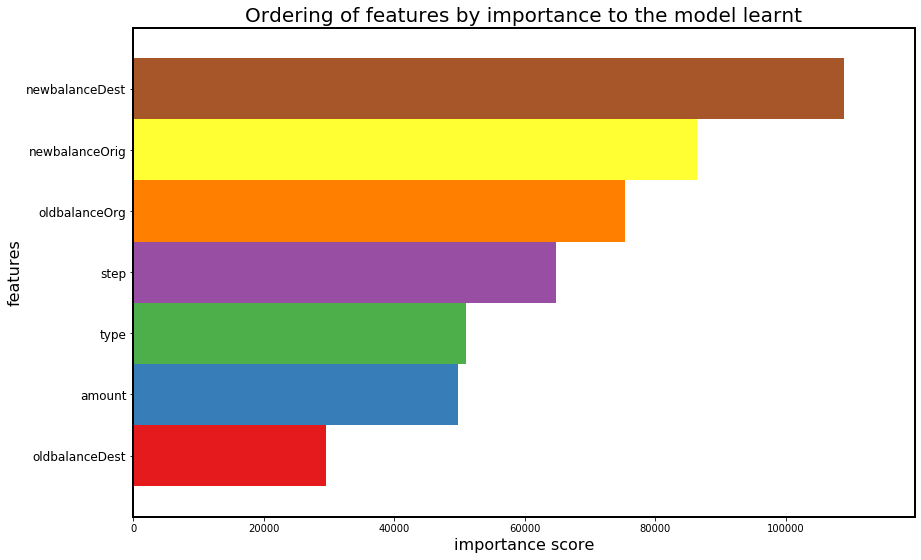

In [19]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(clf, height = 1, color = colours, grid = False, show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);

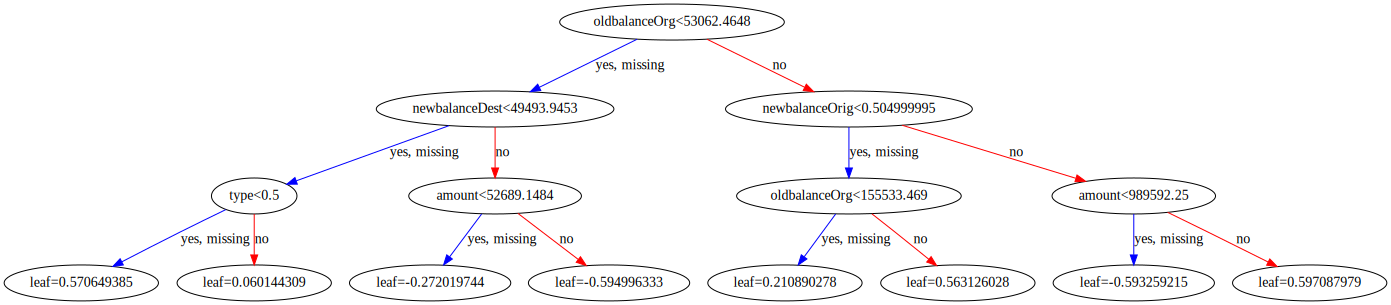

In [21]:
to_graphviz(clf)

In [ ]:
clf.save_model("../fin_pay_fraud.ml")
print("Saved Model")

In [22]:
slf= XGBClassifier()
slf.load_model("../fin_pay_fraud.ml")
print("loaded model")

loaded model


<a href='#top'>back to top</a>